In [ ]:
# try to plot some infos - cf DR with visbrain if time

# Demo 1 - Comparing BCI pipelines with MOABB - Code based on this [tutorial](http://moabb.neurotechx.com/docs/auto_examples/advanced_examples/plot_statistical_analysis.html#sphx-glr-download-auto-examples-advanced-examples-plot-statistical-analysis-py) and this [tutorial](http://moabb.neurotechx.com/docs/auto_examples/plot_benchmark_DL.html#sphx-glr-auto-examples-plot-benchmark-dl-py)

In [ ]:
import matplotlib.pyplot as plt
from mne.decoding import CSP
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC

import moabb
from moabb import benchmark, set_log_level
from moabb.analysis.plotting import score_plot
import moabb.analysis.plotting as moabb_plt
from moabb.analysis.meta_analysis import (  # noqa: E501
    compute_dataset_statistics,
    find_significant_differences,
)
from moabb.datasets import BNCI2014001, Zhou2016, Cho2017
from moabb.evaluations import CrossSessionEvaluation
from moabb.paradigms import LeftRightImagery
from moabb.utils import setup_seed

import tensorflow as tf
from absl.logging import ERROR, set_verbosity
from tensorflow import keras


import seaborn as sns

moabb.set_log_level("info")
# Avoid output Warning
set_verbosity(ERROR)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Print Information Tensorflow
print(f"Tensorflow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")

CPU = len(tf.config.list_physical_devices("CPU")) > 0
print("CPU is", "AVAILABLE" if CPU else "NOT AVAILABLE")

GPU = len(tf.config.list_physical_devices("GPU")) > 0
print("GPU is", "AVAILABLE" if GPU else "NOT AVAILABLE")

print(__doc__)


In [8]:
# pipelines to be compared

pipelines = {}

param_svm = {"kernel": ("linear", "rbf"), "C": [0.1, 1, 10]}
step_csp_svm = [
    ("cov", Covariances(estimator="lwf")),
    ("csp", CSP(6)),
    ("optsvm", GridSearchCV(SVC(), param_svm, cv=3)),
]
pipelines["CSP+optSVM"] = Pipeline(steps=step_csp_svm)


pipelines["CSP+LDA"] = make_pipeline(CSP(n_components=8), LDA())

pipelines["RG+LR"] = make_pipeline(Covariances(), TangentSpace(), LogisticRegression())

pipelines["CSP+LR"] = make_pipeline(CSP(n_components=8), LogisticRegression())

pipelines["RG+LDA"] = make_pipeline(Covariances(), TangentSpace(), LDA())


In [10]:
# evaluation on one dataset

paradigm = LeftRightImagery()
dataset = BNCI2014001()
dataset.subject_list = dataset.subject_list[:4]
datasets = [dataset]
overwrite = True  # set to False if we want to use cached results
evaluation = CrossSessionEvaluation(
    paradigm=paradigm, datasets=datasets, suffix="stats", overwrite=overwrite
)

results = evaluation.process(pipelines)

2023-09-27 17:18:23,310 INFO MainThread moabb.evaluations.base Processing dataset: 001-2014
001-2014-CrossSession:   0%|                                                                                                                                 | 0/4 [00:00<?, ?it/s]2023-09-27 17:18:26,699 INFO MainThread moabb.evaluations.base CSP+optSVM | 001-2014 | 1 | session_E: Score 0.856
2023-09-27 17:18:26,949 INFO MainThread moabb.evaluations.base CSP+optSVM | 001-2014 | 1 | session_T: Score 0.768
2023-09-27 17:18:27,517 INFO MainThread moabb.evaluations.base CSP+LDA | 001-2014 | 1 | session_E: Score 0.955
2023-09-27 17:18:28,064 INFO MainThread moabb.evaluations.base CSP+LDA | 001-2014 | 1 | session_T: Score 0.932
2023-09-27 17:18:28,345 INFO MainThread moabb.evaluations.base RG+LR | 001-2014 | 1 | session_E: Score 0.963
2023-09-27 17:18:28,520 INFO MainThread moabb.evaluations.base RG+LR | 001-2014 | 1 | session_T: Score 0.950
2023-09-27 17:18:29,024 INFO MainThread moabb.evaluations.bas

2023-09-27 17:19:11,382 WARNING MainThread moabb.analysis.plotting Dataset names are too similar, turning off name shortening
/opt/anaconda3/envs/M2-MVA_MEEG_hands-on/lib/python3.10/site-packages/moabb/analysis/plotting.py:59: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sea.stripplot(


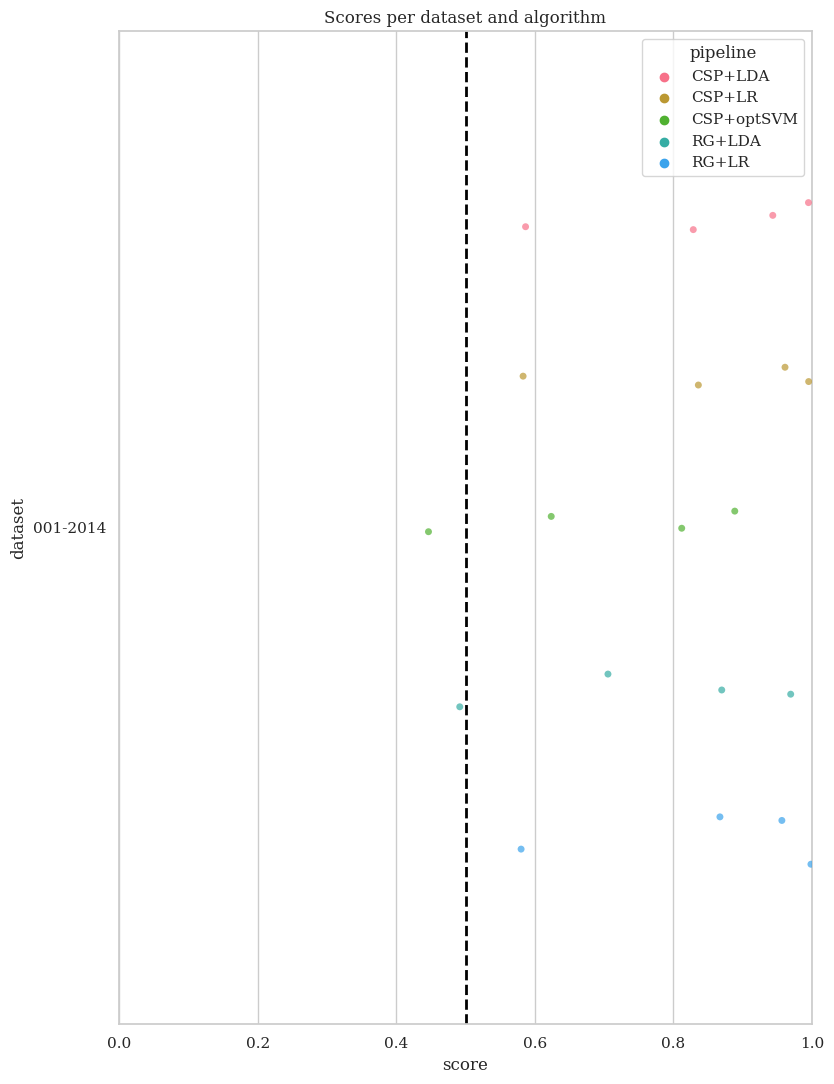

In [11]:
# plot comparison
fig = moabb_plt.score_plot(results)
plt.show()


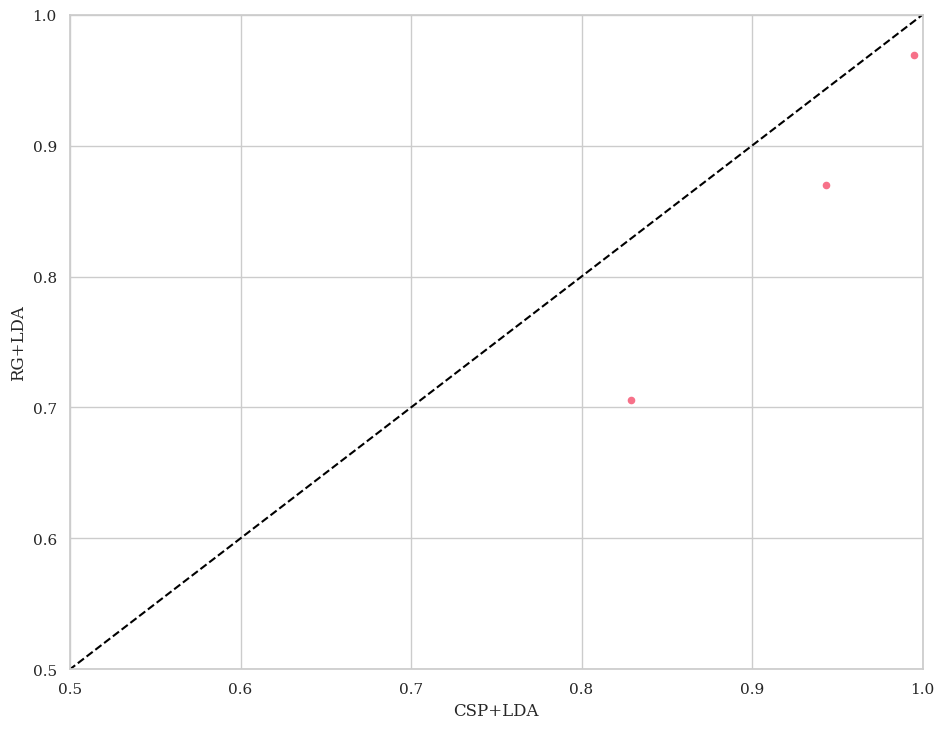

In [16]:
fig = moabb_plt.paired_plot(results, "CSP+LDA", "RG+LDA")
plt.show()



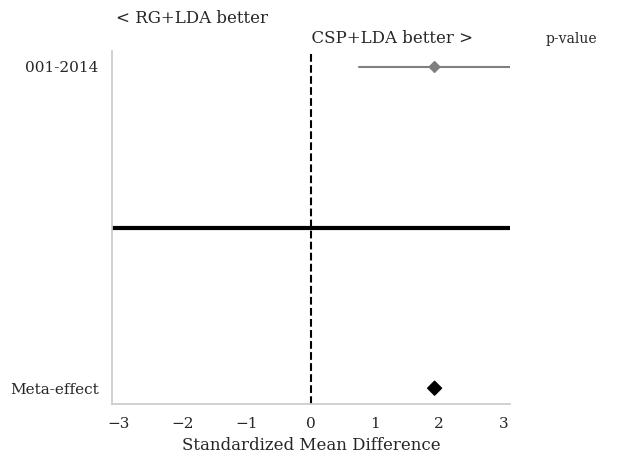

In [13]:
# plot statistical comparison
stats = compute_dataset_statistics(results)
P, T = find_significant_differences(stats)

fig = moabb_plt.meta_analysis_plot(stats, "CSP+LDA", "RG+LDA")
plt.show()

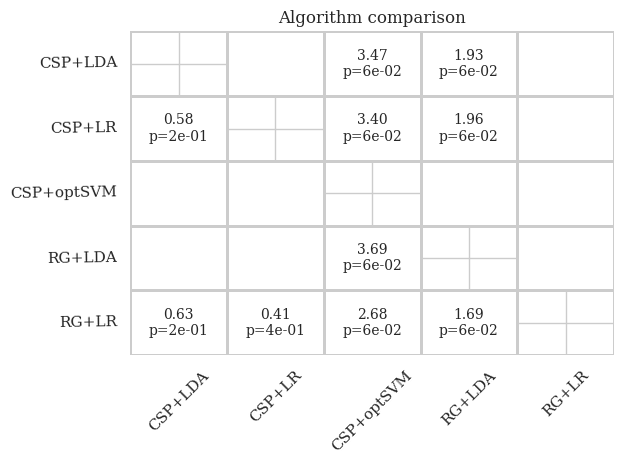

In [14]:
moabb_plt.summary_plot(P, T)
plt.show()

# Demo 2 - Benchmarking with different datasets

In [26]:
paradigm = LeftRightImagery()
subj = [1, 2, 3]
datasets = [BNCI2014001(), Zhou2016()]
for d in datasets:
    d.subject_list = subj

overwrite = True  # set to False if we want to use cached results
evaluation = CrossSessionEvaluation(
    paradigm=paradigm, datasets=datasets, suffix="stats", overwrite=overwrite
)

results = evaluation.process(pipelines)

2023-09-27 17:35:47,468 INFO MainThread moabb.evaluations.base Processing dataset: 001-2014
001-2014-CrossSession:   0%|                                                                                                                                 | 0/3 [00:00<?, ?it/s]2023-09-27 17:35:51,310 INFO MainThread moabb.evaluations.base CSP+optSVM | 001-2014 | 1 | session_E: Score 0.856
2023-09-27 17:35:51,491 INFO MainThread moabb.evaluations.base CSP+optSVM | 001-2014 | 1 | session_T: Score 0.768
2023-09-27 17:35:51,985 INFO MainThread moabb.evaluations.base CSP+LDA | 001-2014 | 1 | session_E: Score 0.955
2023-09-27 17:35:52,462 INFO MainThread moabb.evaluations.base CSP+LDA | 001-2014 | 1 | session_T: Score 0.932
2023-09-27 17:35:52,634 INFO MainThread moabb.evaluations.base RG+LR | 001-2014 | 1 | session_E: Score 0.963
2023-09-27 17:35:52,799 INFO MainThread moabb.evaluations.base RG+LR | 001-2014 | 1 | session_T: Score 0.950
2023-09-27 17:35:53,291 INFO MainThread moabb.evaluations.bas

/opt/anaconda3/envs/M2-MVA_MEEG_hands-on/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


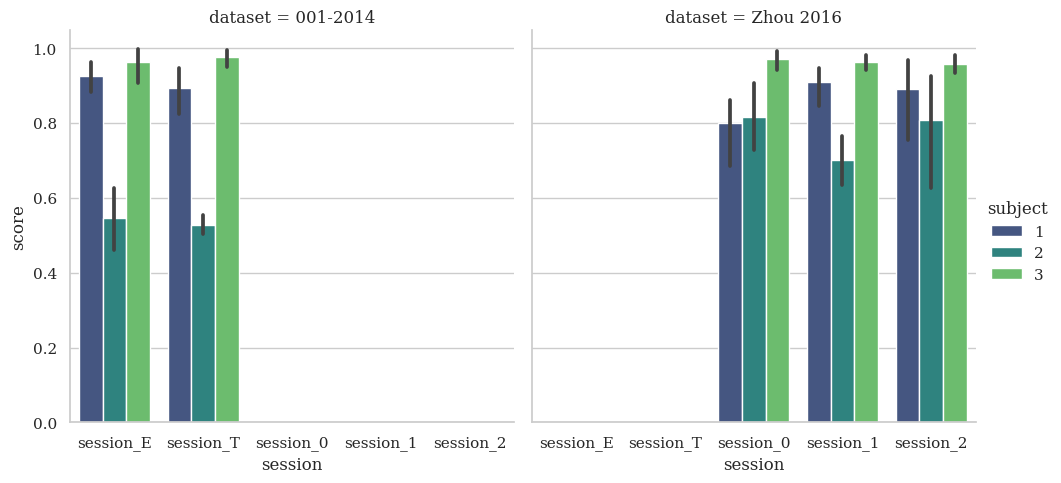

In [21]:

sns.catplot(
    data=results,
    x="session",
    y="score",
    hue="subject",
    col="dataset",
    kind="bar",
    palette="viridis",
)
plt.show()

2023-09-27 17:38:30,575 WARNING MainThread moabb.analysis.plotting Dataset names are too similar, turning off name shortening
/opt/anaconda3/envs/M2-MVA_MEEG_hands-on/lib/python3.10/site-packages/moabb/analysis/plotting.py:59: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sea.stripplot(


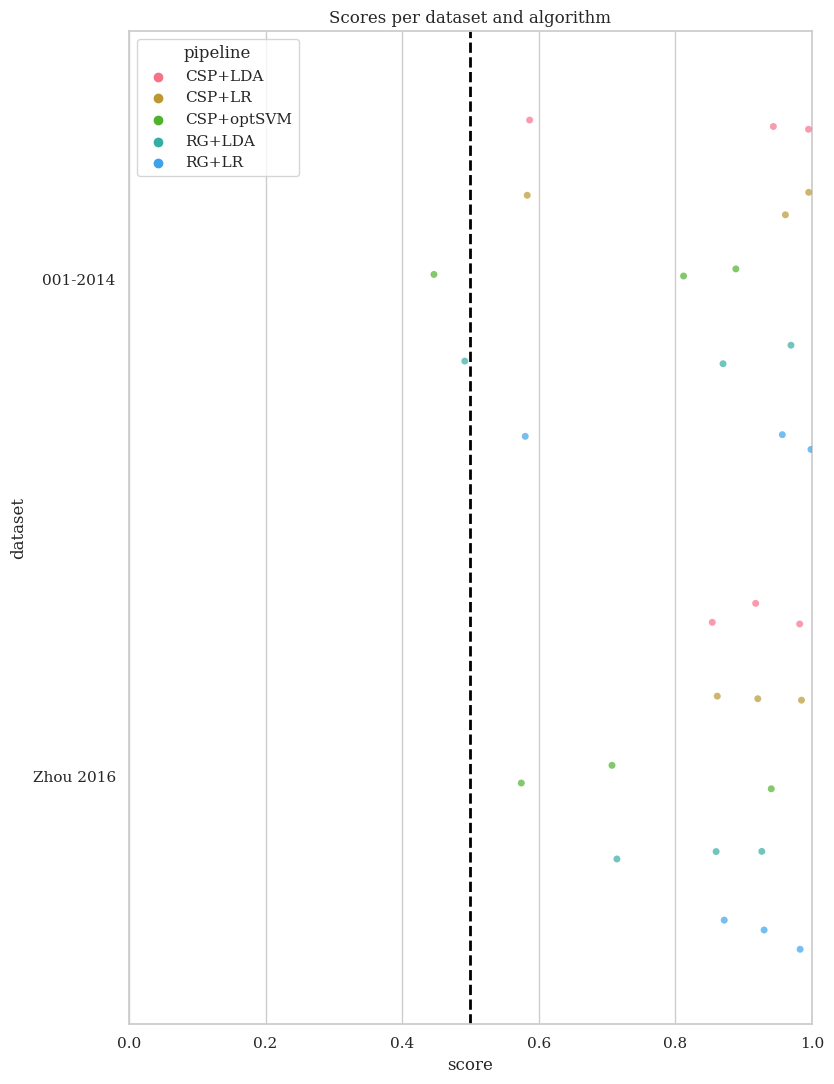

In [34]:
fig = moabb_plt.score_plot(results)
plt.show()

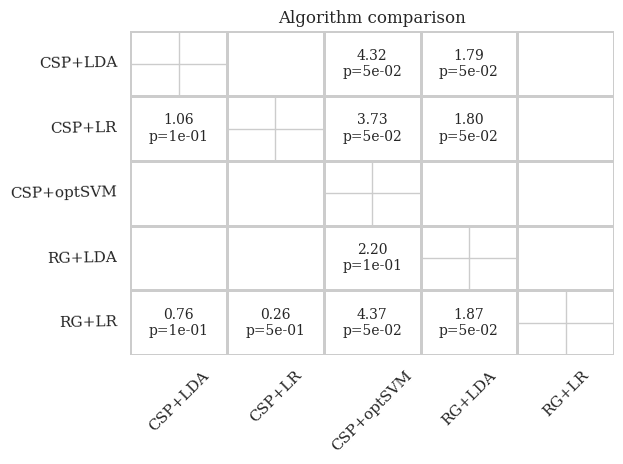

In [36]:
stats = compute_dataset_statistics(results)
P, T = find_significant_differences(stats)
moabb_plt.summary_plot(P, T)
plt.show()


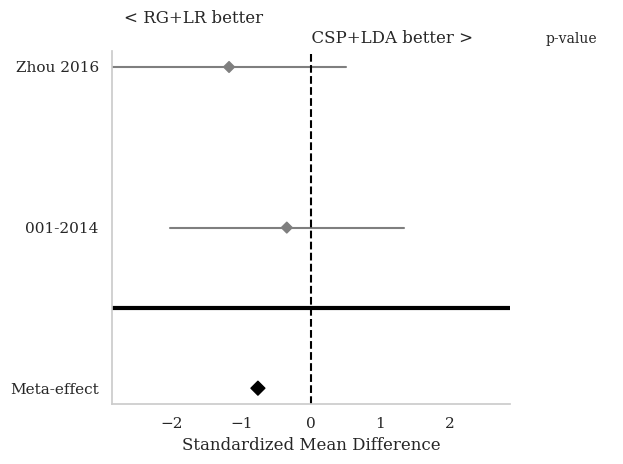

In [37]:
fig = moabb_plt.meta_analysis_plot(stats, "CSP+LDA", "RG+LR")
plt.show()

# Demo 3 - Use of alternative features based on functional connectivity - Code based on this [tutorial](https://pyriemann.readthedocs.io/en/latest/auto_examples/motor-imagery/plot_ensemble_coherence.html)

In [10]:
import matplotlib.pyplot as plt

from mne import Epochs, pick_types, events_from_annotations
from mne.io import concatenate_raws
from mne.io.edf import read_raw_edf
from mne.datasets import eegbci

import numpy as np
import pandas as pd
import seaborn as sns

from pyriemann.classification import FgMDM
from pyriemann.estimation import Covariances, Coherences
from pyriemann.spatialfilters import CSP
from pyriemann.tangentspace import TangentSpace

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC


from helpers.coherence_helpers import (
    NearestSPD,
    get_results,
)

## Connectivity transformer to compute FC estimations

In [5]:
class Connectivities(TransformerMixin, BaseEstimator):
    """Getting connectivity features from epoch"""

    def __init__(self, method="ordinary", fmin=8, fmax=35, fs=None):
        self.method = method
        self.fmin = fmin
        self.fmax = fmax
        self.fs = fs

    def fit(self, X, y=None):
        self._coh = Coherences(
            coh=self.method,
            fmin=self.fmin,
            fmax=self.fmax,
            fs=self.fs,
        )
        return self

    def transform(self, X):
        X_coh = self._coh.fit_transform(X)
        X_con = np.mean(X_coh, axis=-1, keepdims=False)
        return X_con

## EEG data

In [6]:
# avoid classification of evoked responses by using epochs that start 1s after cue onset.
tmin, tmax = 1.0, 2.0
event_id = dict(hands=2, feet=3)
subject = 7
runs = [4, 8]  # motor imagery: left vs right hand

raw_files = [
    read_raw_edf(f, preload=True) for f in eegbci.load_data(subject, runs)
]
raw = concatenate_raws(raw_files)

picks = pick_types(
    raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads"
)
# subsample elecs
picks = picks[::2]

# Apply band-pass filter
raw.filter(7.0, 35.0, method="iir", picks=picks)

events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))

# Read epochs (train will be done only between 1 and 2s)
epochs = Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,
    verbose=False,
)
labels = epochs.events[:, -1] - 2
fs = epochs.info["sfreq"]
X = 1e6 * epochs.get_data()

Download complete in 06s (5.0 MB)
Extracting EDF parameters from /Users/marieconstance.corsi/Documents/GitHub/M2-MVA_MEEG_hands-on_materials/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S007/S007R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/marieconstance.corsi/Documents/GitHub/M2-MVA_MEEG_hands-on_materials/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S007/S007R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 2 contiguous segments
Setting up band-pass filter from 7 - 35 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (

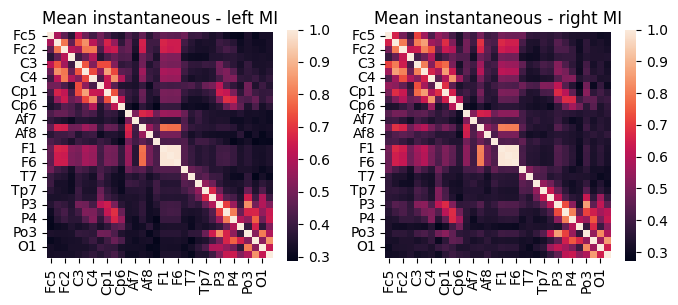

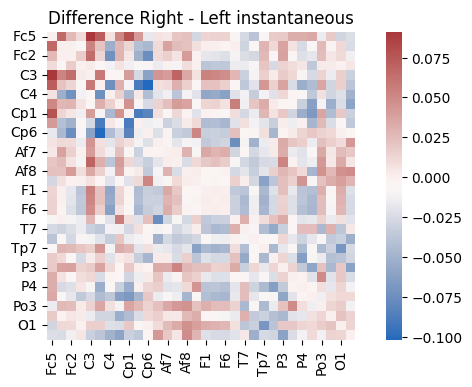

In [193]:
# plot infos features
idx_left=np.where(labels==0)
idx_right=np.where(labels==1)

X_left=np.squeeze(X[idx_left,:,:])
X_right=np.squeeze(X[idx_right,:,:])

mat_connect_left=dict()
mat_connect_right=dict()

param_ft = {"fmin": fmin, "fmax": fmax, "fs": fs}
for sm in spectral_met:
    if sm == "cov":
        Y=Covariances(estimator="lwf").transform(X)
        mat_connect_left[sm]=Y[idx_left,:,:]
        mat_connect_right[sm]=Y[idx_right,:,:]
    else:
        Y=Coherences(coh=sm, fmin=fmin, fmax=fmax, fs=fs).transform(X)
        avg_freqBand=Y.mean(axis=3)
        mat_connect_left[sm]=np.mean(np.squeeze(avg_freqBand[idx_left,:,:]),0) # direct averaged over the trials
        mat_connect_right[sm]=np.mean(np.squeeze(avg_freqBand[idx_right,:,:]),0)
        
        
# plot FC
sm=spectral_met[2]

fig, axes = plt.subplots(1,2, figsize=[8, 3])
ch_names = [ch.replace('.', '') for ch in epochs.ch_names]

df = pd.DataFrame(data=mat_connect_left[sm], index=ch_names, columns=ch_names)
g = sns.heatmap(
                df, ax=axes[0], square=True, cbar=True, xticklabels=2, yticklabels=2)
g.set_title('Mean ' + sm + ' - left MI')

df = pd.DataFrame(data=mat_connect_right[sm], index=ch_names, columns=ch_names)
g = sns.heatmap(
                df, ax=axes[1], square=True, cbar=True, xticklabels=2, yticklabels=2)
g.set_title('Mean ' + sm + ' - right MI')

plt.xticks(rotation='vertical')
plt.yticks(rotation='horizontal')
plt.show()


fig, axes = plt.subplots(figsize=[8, 4])
ch_names = [ch.replace('.', '') for ch in epochs.ch_names]

df = pd.DataFrame(data=mat_connect_right[sm]-mat_connect_left[sm], index=ch_names, columns=ch_names)
g = sns.heatmap(
                df, ax=axes, square=True, cbar=True, xticklabels=2, yticklabels=2, cmap="vlag")
g.set_title('Difference Right - Left ' + sm )

plt.xticks(rotation='vertical')
plt.yticks(rotation='horizontal')
plt.show()

## Pipelines definition

Here we are going to compare different methods: CSP+shLDA, CSP+SVM, FgMDM on covariance, tangent space logistic regression with covariance, lag coherence, and instantaneous coherence, along with ensemble method - *TODO: add more?*

In [27]:
ppl_baseline, ppl_fc, ppl_ens = {}, {}, {}

In [28]:
# Baseline pipelines
param_svm = {"kernel": ("linear", "rbf"), "C": [0.1, 1, 10]}
step_csp_svm = [
    ("cov", Covariances(estimator="lwf")),
    ("csp", CSP(nfilter=6)),
    ("optsvm", GridSearchCV(SVC(), param_svm, cv=3)),
]
ppl_baseline["CSP+optSVM"] = Pipeline(steps=step_csp_svm)


step_mdm = [
    ("cov", Covariances(estimator="lwf")),
    ("fgmdm", FgMDM(metric="riemann", tsupdate=False)),
]
ppl_baseline["FgMDM"] = Pipeline(steps=step_mdm)


In [29]:
# Functional connectivity pipelines
spectral_met = ["cov", "lagged", "instantaneous"]
fmin, fmax = 8, 35
param_lr = {
    "penalty": "elasticnet",
    "l1_ratio": 0.15,
    "intercept_scaling": 1000.0,
    "solver": "saga",
}
param_ft = {"fmin": fmin, "fmax": fmax, "fs": fs}
step_fc = [
    ("spd", NearestSPD()),
    ("tg", TangentSpace(metric="riemann")),
    ("LogistReg", LogisticRegression(**param_lr)),
]
for sm in spectral_met:
    pname = sm + "+elasticnet"
    if sm == "cov":
        ppl_fc[pname] = Pipeline(
            steps=[("cov", Covariances(estimator="lwf"))] + step_fc
        )
    else:
        ft = Connectivities(**param_ft, method=sm)
        ppl_fc[pname] = Pipeline(steps=[("ft", ft)] + step_fc)

In [30]:
# Ensemble classifier
fc_estim = [(n, ppl_fc[n]) for n in ppl_fc]
cvkf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

lr = LogisticRegression(**param_lr)
ppl_ens["ensemble"] = StackingClassifier(
    estimators=fc_estim,
    cv=cvkf,
    n_jobs=1,
    final_estimator=lr,
    stack_method="predict_proba",
)

### Evaluation

In [194]:
dataset_res = list()
all_ppl = {**ppl_baseline, **ppl_ens}
#print(all_ppl)

In [32]:
# Compute results
results = get_results(X, labels, all_ppl)
results = pd.DataFrame(results)

/opt/anaconda3/envs/M2-MVA_MEEG_hands-on/lib/python3.10/site-packages/pyriemann/utils/mean.py:522: UserWarning: Convergence not reached
  warnings.warn("Convergence not reached")
/opt/anaconda3/envs/M2-MVA_MEEG_hands-on/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/M2-MVA_MEEG_hands-on/lib/python3.10/site-packages/pyriemann/utils/mean.py:522: UserWarning: Convergence not reached
  warnings.warn("Convergence not reached")
/opt/anaconda3/envs/M2-MVA_MEEG_hands-on/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/M2-MVA_MEEG_hands-on/lib/python3.10/site-packages/pyriemann/utils/mean.py:522: UserWarning: Convergence not reached
  warnings.warn("Convergence not reached")
/opt/anaconda3/envs/M2-MVA_MEEG_hands-on/lib/python3.

In [195]:
results

,score,pipeline,split,samples
0,0.750000,CSP+optSVM,0,30
1,0.750000,FgMDM,0,30
2,1.000000,ensemble,0,30
3,0.750000,cov+elasticnet,0,30
4,0.125000,lagged+elasticnet,0,30
5,0.500000,instantaneous+elasticnet,0,30
6,0.666667,CSP+optSVM,1,30
7,0.666667,FgMDM,1,30
8,0.833333,ensemble,1,30
9,0.833333,cov+elasticnet,1,30


/opt/anaconda3/envs/M2-MVA_MEEG_hands-on/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


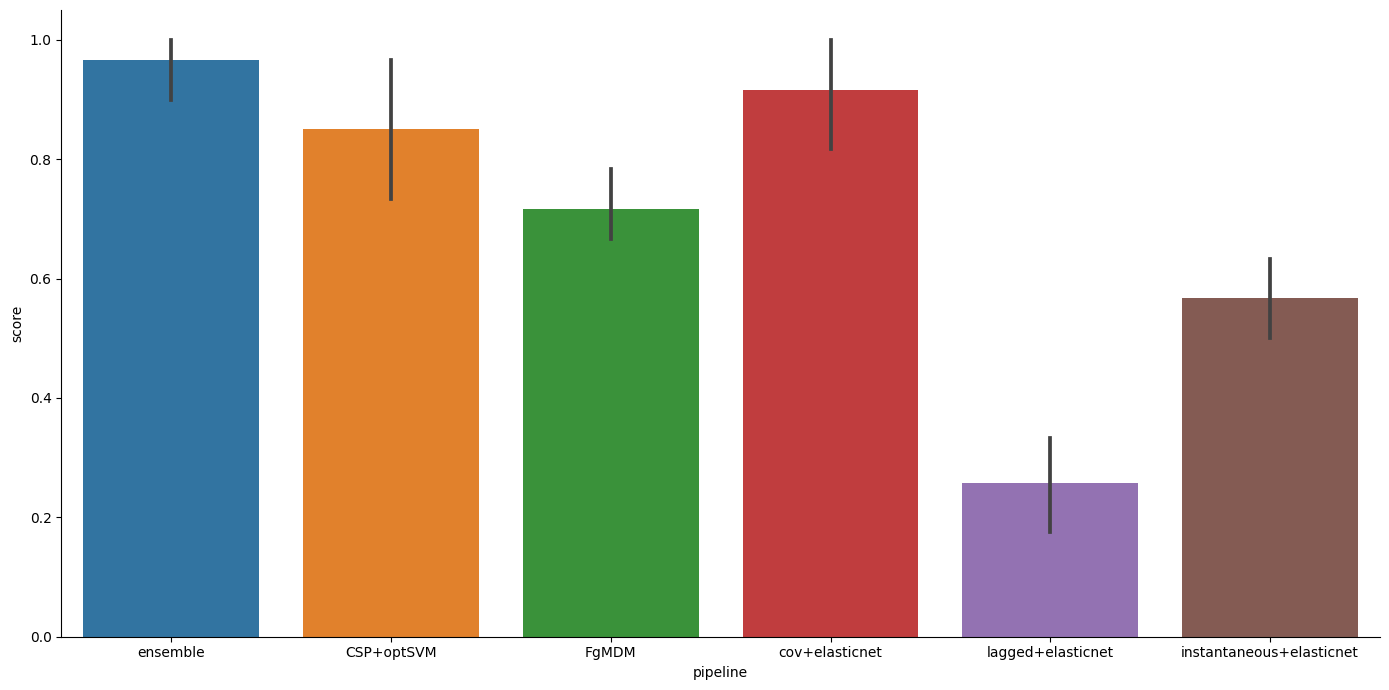

In [45]:
# plot results
list_fc_ens = ["ensemble", "CSP+optSVM", "FgMDM"] + \
    [sm + "+elasticnet" for sm in spectral_met]

g = sns.catplot(
    data=results,
    x="pipeline",
    y="score",
    kind="bar",
    order=list_fc_ens,
    height=7,
    aspect=2,
)
plt.show()

# Demo 4 - benchmarking DL methods - Code based on this [tutorial](http://moabb.neurotechx.com/docs/auto_examples/plot_benchmark_DL.html#sphx-glr-auto-examples-plot-benchmark-dl-py)